# Time Series 2. Sktime

Task: Use Sktime library for forecasting. Try pipelines, hyperparameters tuning, ensembles. Get the best score according to MAPE.

In [ ]:
# !pip install sktime[all_extras]

In [ ]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

## Data preparation

### Visualization 

In [ ]:
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

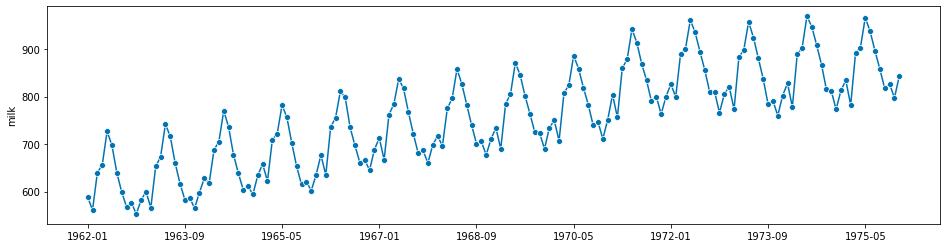

In [ ]:
y = pd.read_csv('monthly-milk-production.csv', 
                 parse_dates=['month'],
                 index_col='month').milk
y.index = y.index.to_period('M')

plot_series(y)

### Splitting into test-train

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=36)    

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

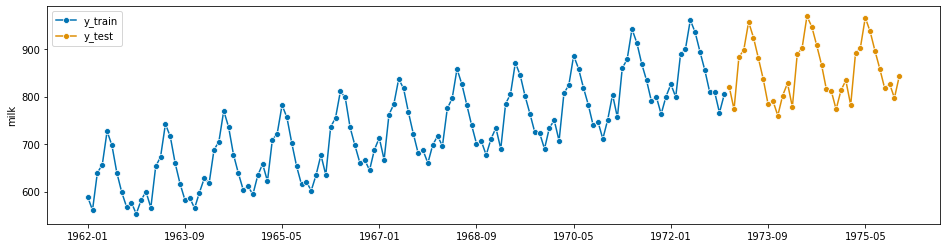

In [ ]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

## Model selection

### Applying naive model

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

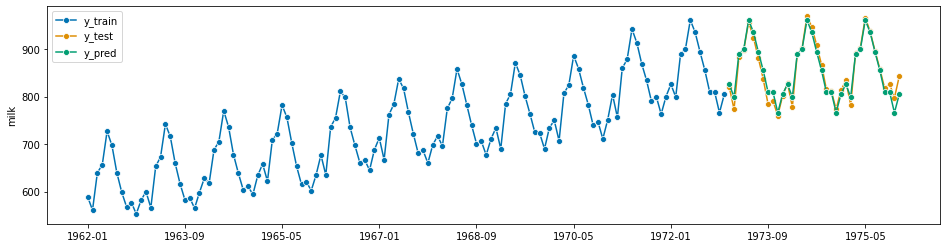

In [ ]:
forecaster = NaiveForecaster(strategy='last', sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

In [ ]:
mape(y_test, y_pred)

0.012384685514559738

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

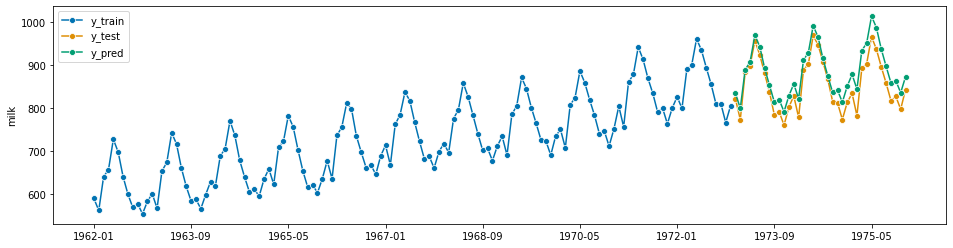

In [ ]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.034041657351653

In [ ]:
from sktime.forecasting.ets import AutoETS

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

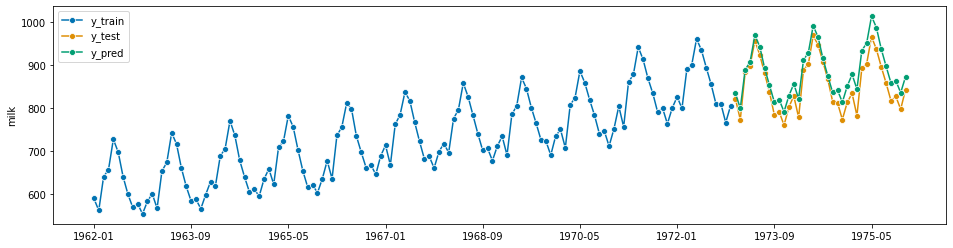

In [ ]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
y_train = y_train.astype(float)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.03406221687146782

## SARIMA models

In [ ]:
from sktime.forecasting.arima import ARIMA

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

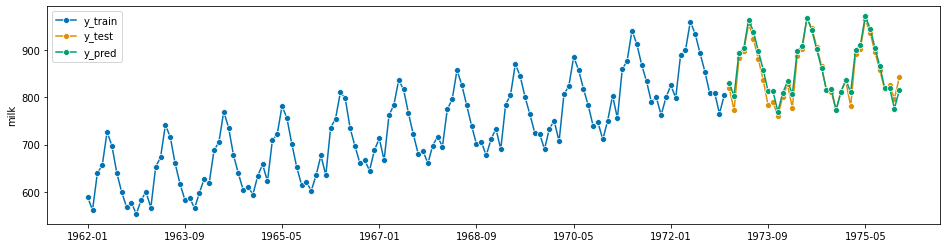

In [ ]:
# trying parameters from previous hw
forecaster = ARIMA(order=(1, 1, 0), 
                   seasonal_order=(0, 1, 0, 12), 
                   suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.013376560841576951

In [ ]:
from sktime.forecasting.arima import AutoARIMA

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

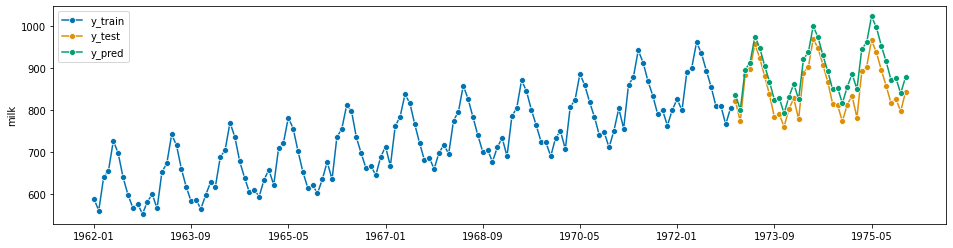

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.04370447844169213

In [ ]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -408.664
Date:                              Sat, 18 Sep 2021   AIC                            827.328
Time:                                      06:40:49   BIC                            841.266
Sample:                                           0   HQIC                           832.988
                                              - 132                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5927      1.566      2.294      0.022       0.523       6.663
ar.L1          0.6135      0.106      5.787      0.000       0.406       0.821
ar.L2          0.2325      0.094      2.463      0.014       0.047       0.417
ma.S.L12      -0.6153      0.093     -6.587      0.000      -0.798      -0.432
sigma2        50.3252      5.976      8.421      0.000      38.612      62.039
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                42.00
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.92
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Pipelines

In [ ]:
from sktime.transformations.series.detrend import Detrender, Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import TransformedTargetForecaster

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

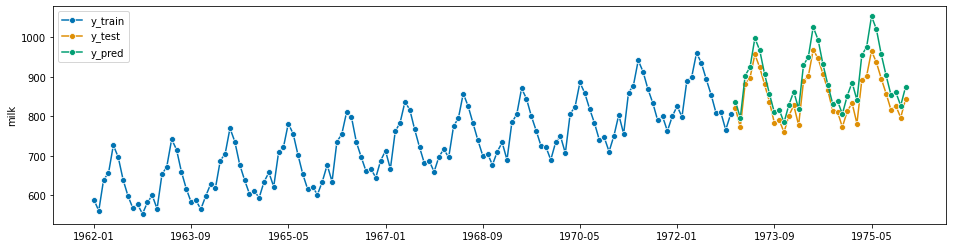

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", ARIMA(order=(1, 0, 0))),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.044077908682824345

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

0.038791063282881705

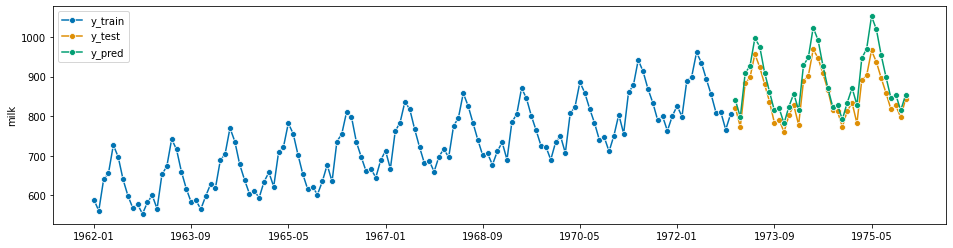

In [ ]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            make_reduction(
                KNeighborsRegressor(),
                scitype="tabular-regressor",
                window_length=15,
                strategy="recursive",
            ),
        ),
    ]
)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape(y_pred, y_test)

## Tuning

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
param_grid = {"window_length": [7, 12, 15], "estimator__n_neighbors": np.arange(1, 10)}

regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, strategy="recursive")

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=30)
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid
)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='milk'>)

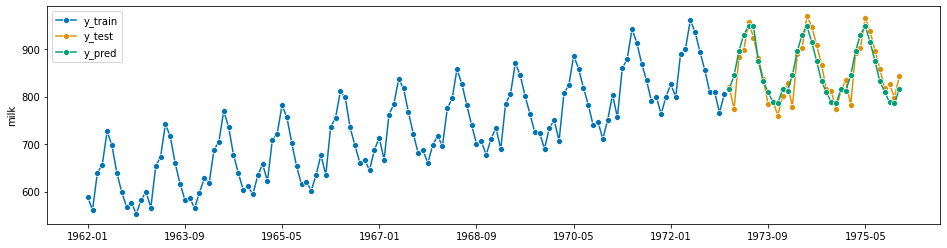

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
mape(y_pred, y_test)

0.026335185237202803

In [ ]:
gscv.best_params_

{'estimator__n_neighbors': 2, 'window_length': 12}

## Ensembles

In [ ]:
from sktime.forecasting.compose import EnsembleForecaster

0.019404798539727774

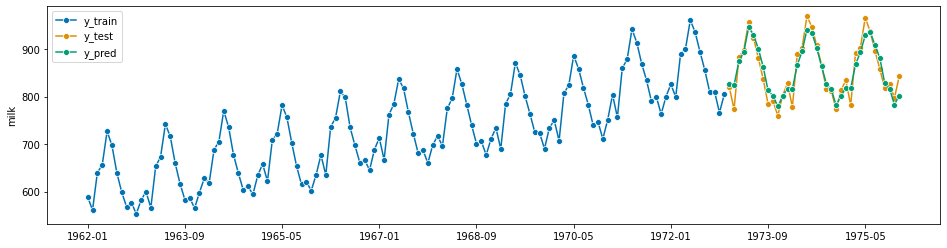

In [ ]:
arima = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), suppress_warnings=True)
regressor = KNeighborsRegressor()
knn = make_reduction(regressor, strategy="recursive")

forecaster = EnsembleForecaster(
    [
        ("arima", arima),
        ("knn", knn)
        
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mape(y_pred, y_test)

Best scores - ARIMA((1, 1, 0),(0, 1, 0, 12)), knn.